In [333]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


data_path = "/home/clairegayral/Documents/openclassroom/data/P5/"
res_path = "/home/clairegayral/Documents/openclassroom/res/P5/"

## my .py : 
from script01_duplicates import *
from script02_missing_values_treatment import *
from script03_univariate_analysis import *
from script04_multivariate_analysis import *
from script05_CV_regression import *
from script06_reduce_dim import *

## extract list of text :
from bs4 import BeautifulSoup
import re
# from sklearn.feature_extraction.s import s# import ENGLISH_STOP_WORDS

# from sklearn import model_selection 
# from sklearn import preprocessing
# from sklearn import neighbors
# from sklearn import linear_model

# from sklearn.impute import KNNImputer
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
# from sklearn.cluster import AgglomerativeClustering
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import fbeta_score
# from sklearn.metrics import make_scorer
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import fowlkes_mallows_score
# from sklearn.metrics.pairwise import pairwise_kernels


# from sklearn.preprocessing import OneHotEncoder
# from sklearn.linear_model import LogisticRegression

# from scipy.cluster.hierarchy import cut_tree
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram


from bs4 import BeautifulSoup
import nltk
from collections import defaultdict
from nltk.stem.snowball import EnglishStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.utils import tokenize
from gensim import corpora
from gensim import models
from gensim.models import FastText

# Mission

Dans un premier notebook, les posts tagués ont été extraits, et prétraités. De ce travail, les textes sont laissés sous forme de "bag of word", une liste de mots d'intérêt appelés tokens. Pour les variables de sortie dans l'apprentissage supervisé, seulement quelques tags sont gardés, afin de limiter la complexité de calculs. Il sera possible de généraliser cela.

## Rappel des consignes :

* Mettre en œuvre une approche non supervisée.
* Utiliser une approche supervisée ou non pour extraire des tags à partir des résultats précédents.
* Comparer ses résultats à une approche purement supervisée, après avoir appliqué des méthodes d’extraction de features spécifiques des données textuelles.
* Mettre en place une méthode d’évaluation propre, avec une séparation du jeu de données pour l’évaluation.
* Pour suivre les modifications du code final à déployer, utiliser un logiciel de gestion de versions, par exemple Git.


## Livrable attendu ici
Un notebook de test de différents modèles (non cleané, pour comprendre votre démarche)


# Ressources : 
## LDA 
* Une explication générale : https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2
* Un cours plus détaillé (approche plus proba) : https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiykLO95Yj1AhWkzYUKHT2hBI4QFnoECAUQAQ&url=http%3A%2F%2Falberto.bietti.me%2Ffiles%2Frapport-lda.pdf&usg=AOvVaw1tuLV60ncpf3PIqb3PN0DE
* 3eme ressource : https://www.analyticsvidhya.com/blog/2021/06/part-2-topic-modeling-and-latent-dirichlet-allocation-lda-using-gensim-and-sklearn/


* LDA sklearn documentation : https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
## Gradient Boosting :

# Plan du notebook :

Pour faciliter la lecture, il est possible de revenir à ce sommaire, en cliquant sur [back to menu](#menu) chaque fois qu'il apparaît. A partir de ce menu, il est possible de naviguer entre les parties en cliquant sur leur titre.


<a id ="menu"></a>
1. [Les posts](#section1)
    1. [Import du travail précédent](#section1.1)
    2. [Séparation des données](#section1.2)
    
2. [Approche non supervisée](#section2)
    1. [LDA - code de base](#section2.1)
    2. [Comparaison LDA/NMF](#section2.2)
    3. [Optimisation des hyper-paramètres du LDA](#section2.3)
    4. [LDA - modèle sur test](#section2.4)
3. [Approche supervisée](#section3)
    1. [Gradient Boosting](#section3.1)
        2. [](#section3.1.1)
        3. [](#section3.1.2)
        4. [](#section3.1.3)   
    2. [Bert ?](#section3.2)
        1. [](#section3.2.1)
        2. [](#section3.2.2)
        3. [](#section3.2.3)       
        4. [](#section3.2.4)

<a id ="section1"></a>
<a id ="section1.1"></a>

[back to menu](#menu)

# 1.Les posts
## 1.A Import du travail précédent

In [394]:
## Posts Lemmatized :
with open(res_path+"posts_cleanned_corpora_tokens"+".pkl", "rb") as f :
    corpora = pickle.load(f)
len(corpora)

11095

Comme proposé dans [ce post](https://thatascience.com/learn-machine-learning/save/), j'utilise la fonction "CountVectorizer" de sklearn pour passer en one ot encoding (sans visualisation possible car matrice sparse)

In [336]:
countvec = CountVectorizer(ngram_range=(1,4), 
                           stop_words='english',  
                           strip_accents='unicode',
                           max_features=10000)
X = countvec.fit_transform(pd.Series(corpora))
X

<11095x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 325452 stored elements in Compressed Sparse Row format>

In [337]:
X_df = pd.DataFrame(X.toarray(), index=corpora.keys())

In [338]:
## passer en list de tokens : 
# {k:text.split(" ") for k,text in corpora.items()}

In [412]:
## tags :
## one of the original tags :
with open(res_path+"y_uniclass"+".pkl", "rb") as f :
    y = pickle.load(f)
    
## 3 meta-tags from clustering :
with open(res_path+"y_multiclass"+".pkl", "rb") as f :
    Y = pickle.load(f)

<a id ="section1.2"></a>
[back to menu](#menu)


## 1.B Séparation des posts 

Pour comparer les données, je vais séparer mon ensemble de posts en apprentissage et test. Le premier servira à apprendre les modèles, le deuxième à comparer les prédictions entre les différents modèles 

In [340]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X_df)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
88962,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35560,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65512,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40603,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34399,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Et pour avoir accès aux indices : 

In [341]:
train_index = X_train.index#pd.DataFrame(X.toarray(), index = list(corpora.keys())).iloc[X_train.indices,:].index
test_index = X_test.index

Pour être consistant entre les modèles suivants, j'enregistre cette spéaration train/test : 

In [342]:
# with open(res_path+"train_test_split"+".pkl", "wb") as f :
#     pickle.dump((train_index,test_index), f, pickle.HIGHEST_PROTOCOL)

Je peux donc partir de cette cellule pour la suite : 

In [343]:
## open corpora : 
with open(res_path+"posts_cleanned_corpora_tokens"+".pkl", "rb") as f :
    corpora = pickle.load(f)
## import train/test split index :    
with open(res_path+"train_test_split"+".pkl", "rb") as f :
    (train_index,test_index) = pickle.load(f)

n_features = 1000 
## choose vectorizer : 
countvec = CountVectorizer(max_features=n_features,
                          stop_words='english', strip_accents='unicode',)
X = countvec.fit_transform(pd.Series(corpora))
## get right index and split :
X = pd.DataFrame(X.toarray(), index = corpora.keys())
X_train = X.loc[train_index,:]
X_test = X.loc[test_index,:]

In [344]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
44917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92617,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37525,0,0,0,0,1,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
87818,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2138,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
75156,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59786,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
88269,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0


<a id ="section1.3"></a>
[back to menu](#menu)

## 1.C Séparation des tags 
J'utilise le même index pour extraire les tags de train et test : 
### Univarié (label le plus fréquent)

In [402]:
y_train = y[train_index]
y_test = y[test_index]

### Multivarié (axes du NMF donné sur les tags) :

In [418]:
Y_train = Y.loc[train_index]
Y_test = Y.loc[test_index]

<a id ="section2"></a>
<a id ="section2.1"></a>
[back to menu](#menu)

# 2. Approche non supervisé
## 2.A LDA - code de base 
Pour lancer la LDA, la [documentation de sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) est très claire. [Cet article](https://yanlinc.medium.com/how-to-build-a-lda-topic-model-using-from-text-601cdcbfd3a6) propose un tuto pour l'implémentation. A noter : gensim propose aussi une implémentation de la LDA, [qui avait l'air assez facile à prendre en main](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24)

In [345]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(X_train)

LatentDirichletAllocation(n_components=5, random_state=0)

In [346]:
lda.transform(X_test)

array([[5.52925013e-01, 1.67497105e-02, 3.96442572e-01, 1.67152722e-02,
        1.71674324e-02],
       [8.68368357e-01, 8.07268432e-03, 8.22684357e-03, 8.07177979e-03,
        1.07260336e-01],
       [5.75771957e-04, 5.62578844e-04, 7.69020420e-02, 5.63969134e-04,
        9.21395638e-01],
       ...,
       [5.65180521e-03, 6.53946784e-01, 5.73821606e-03, 3.28934805e-01,
        5.72838956e-03],
       [6.10911659e-01, 7.83239771e-03, 7.98487692e-03, 1.64698251e-01,
        2.08572815e-01],
       [7.78156029e-03, 7.78756336e-03, 7.91302881e-03, 7.32659742e-01,
        2.43858106e-01]])

Pour interpréter les résultats cependant, ce n'est pas si simple. D'autant qu'il faut tester différentes valeurs de n_components, mais aussi le learning_decay. Pour aller plus vite, penser à choisir n_jobs (parallèlisation) 

<a id ="section2.2"></a>
[back to menu](#menu)

## 2.B Comparaison LDA/NMF 
[Une page de scikit](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py) propose de comparer différentes méthodes d'extraction de topic. J'ai modifié le code pour le lancer sur mes postes stackoverflow : 

In [347]:
# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

print("Loading dataset...")
t0 = time.time()
data_samples = [corpora[k] for k in train_index]
print("done in %0.3fs." % (time.time() - t0))

Loading dataset...
done in 0.002s.


In [348]:
n_features = 1000
n_components = 10
n_samples = 2000
n_top_words = 20

In [389]:
# from time.time import time.time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

def plot_top_words(model, feature_names, n_top_words, title, n5 = 2):
    ## n5 = number of lines filled will 5 plot
    fig, axes = plt.subplots(n5, 5, figsize=(30, 6*n5), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_[:5*n5]):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.tight_layout()
    plt.show()

In [390]:
## Preprocess text :

# Use tf-idf features for NMF 
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, )
    #stop_words="english") ## already removed
t0 = time.time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time.time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features,# stop_words="english"
)
t0 = time.time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time.time() - t0))
print()

Extracting tf-idf features for NMF...
done in 0.156s.
Extracting tf features for LDA...
done in 0.159s.



Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.123s.


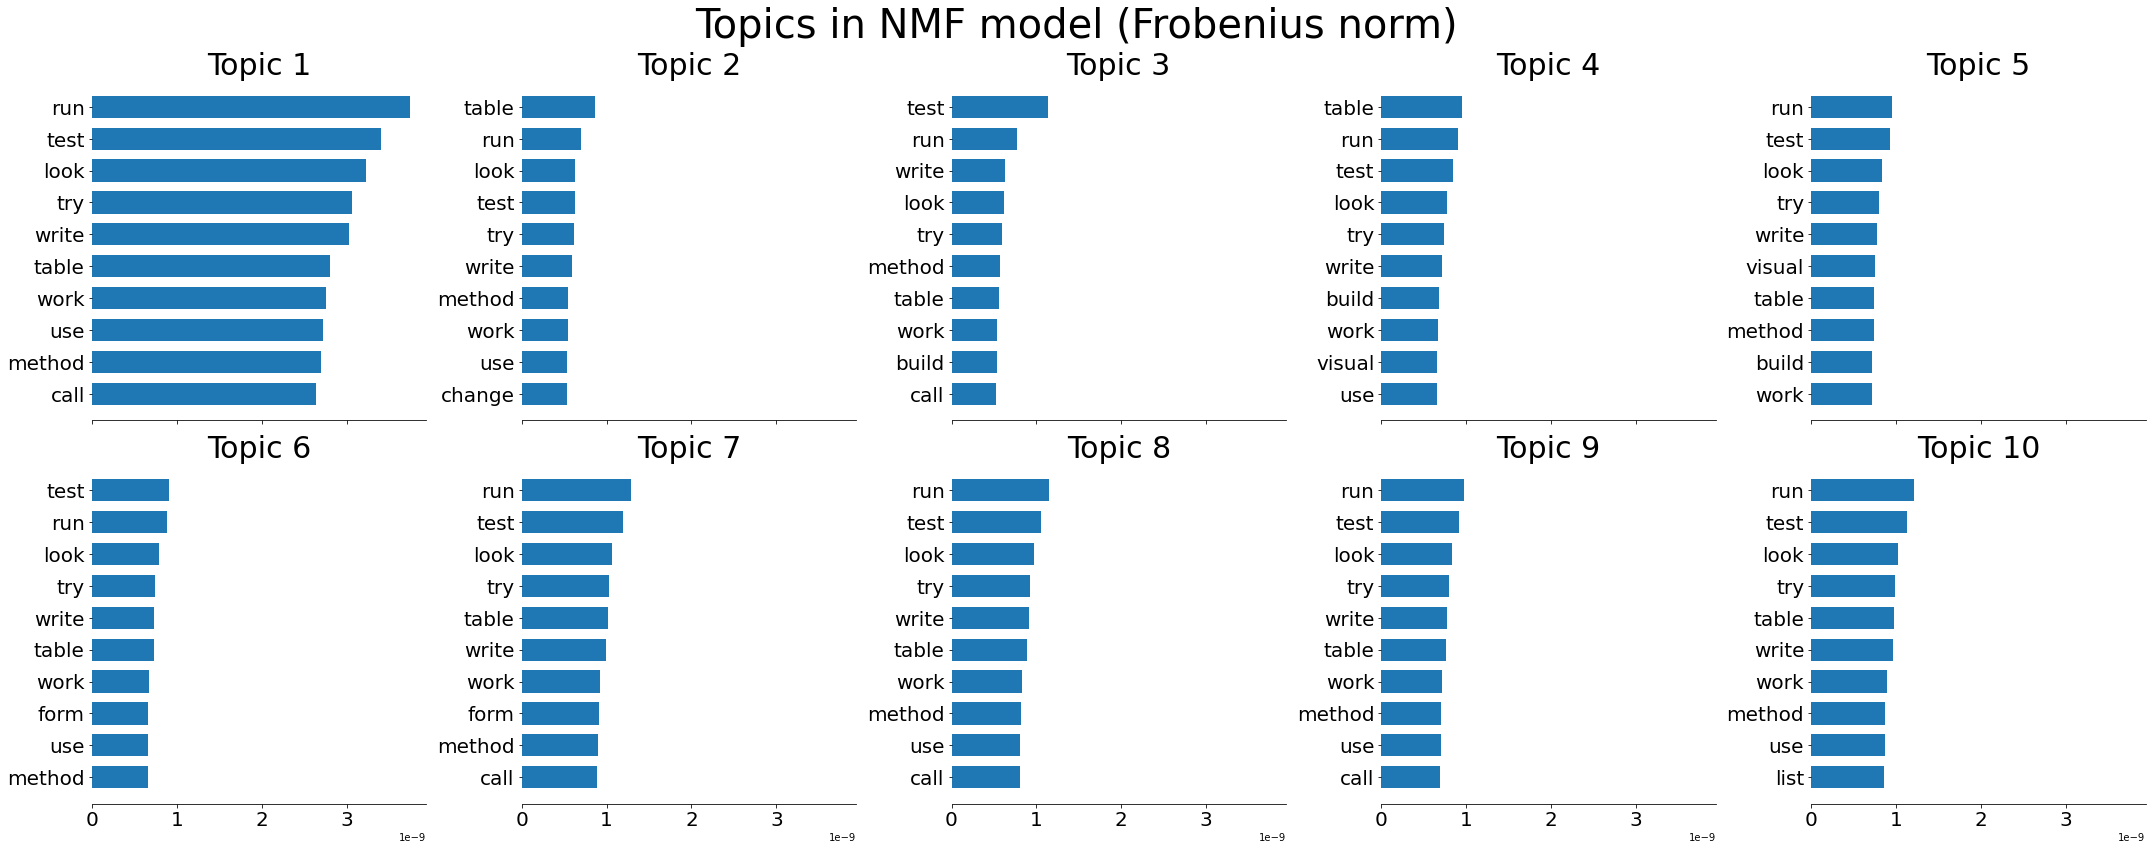

In [391]:
# Fit the NMF model with Frobenius norm :
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    "n_samples=%d and n_features=%d..." % (n_samples, n_features)
)
t0 = time.time()
nmf = NMF(n_components=n_components, 
          init='nndsvd', #random_state=1,
          alpha_W=0.1, alpha_H="same", l1_ratio=0) ## pas de pénalisation L1 sinon 0 partout
nmf = nmf.fit(tfidf)
print("done in %0.3fs." % (time.time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words( nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)")



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.584s.


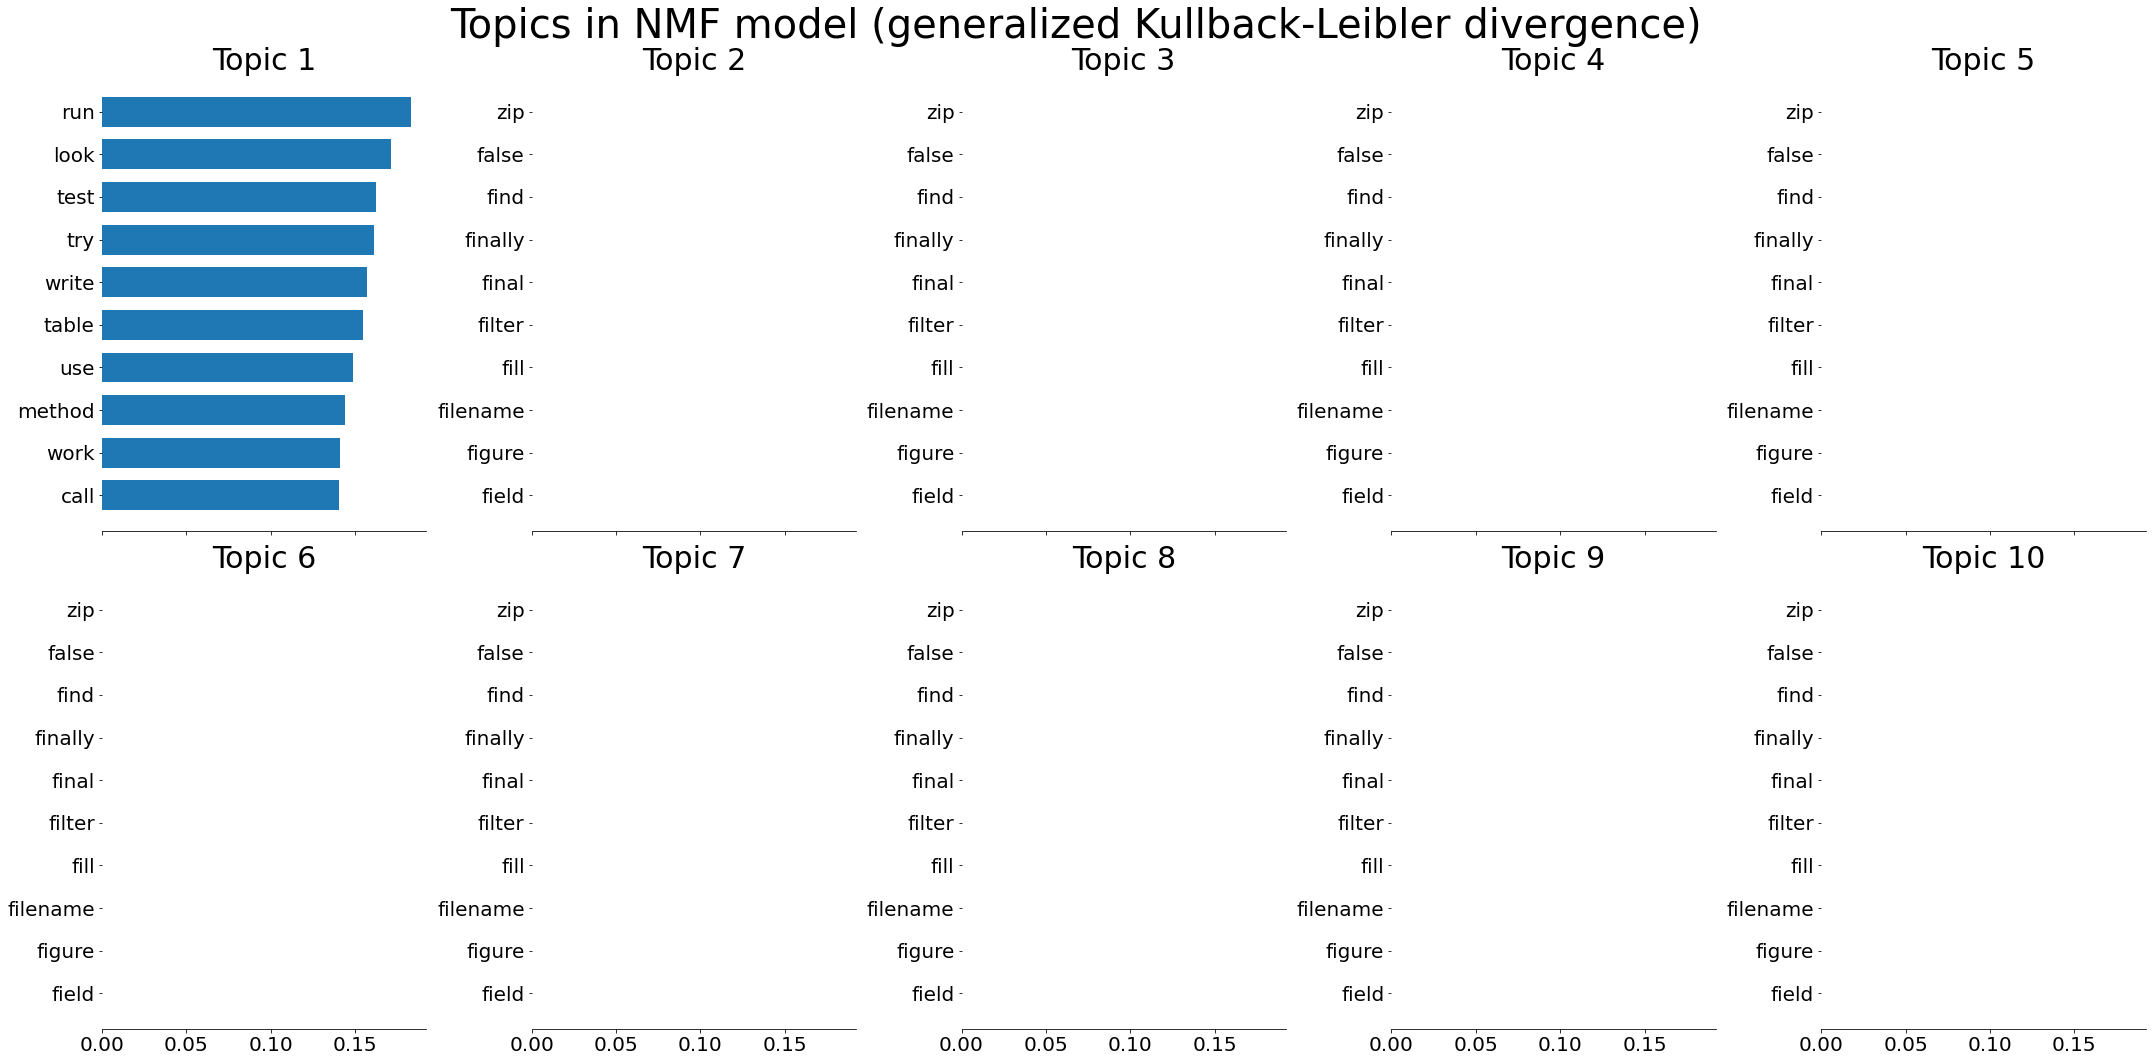

In [382]:
# Fit the NMF model with KL divergence
print(
    "\n" * 2,
    "Fitting the NMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
t0 = time.time()
nmf = NMF(
    n_components=n_components,init = "nndsvda",
    random_state=1,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.1, alpha_H="same",
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time.time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)



 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...
done in 6.842s.


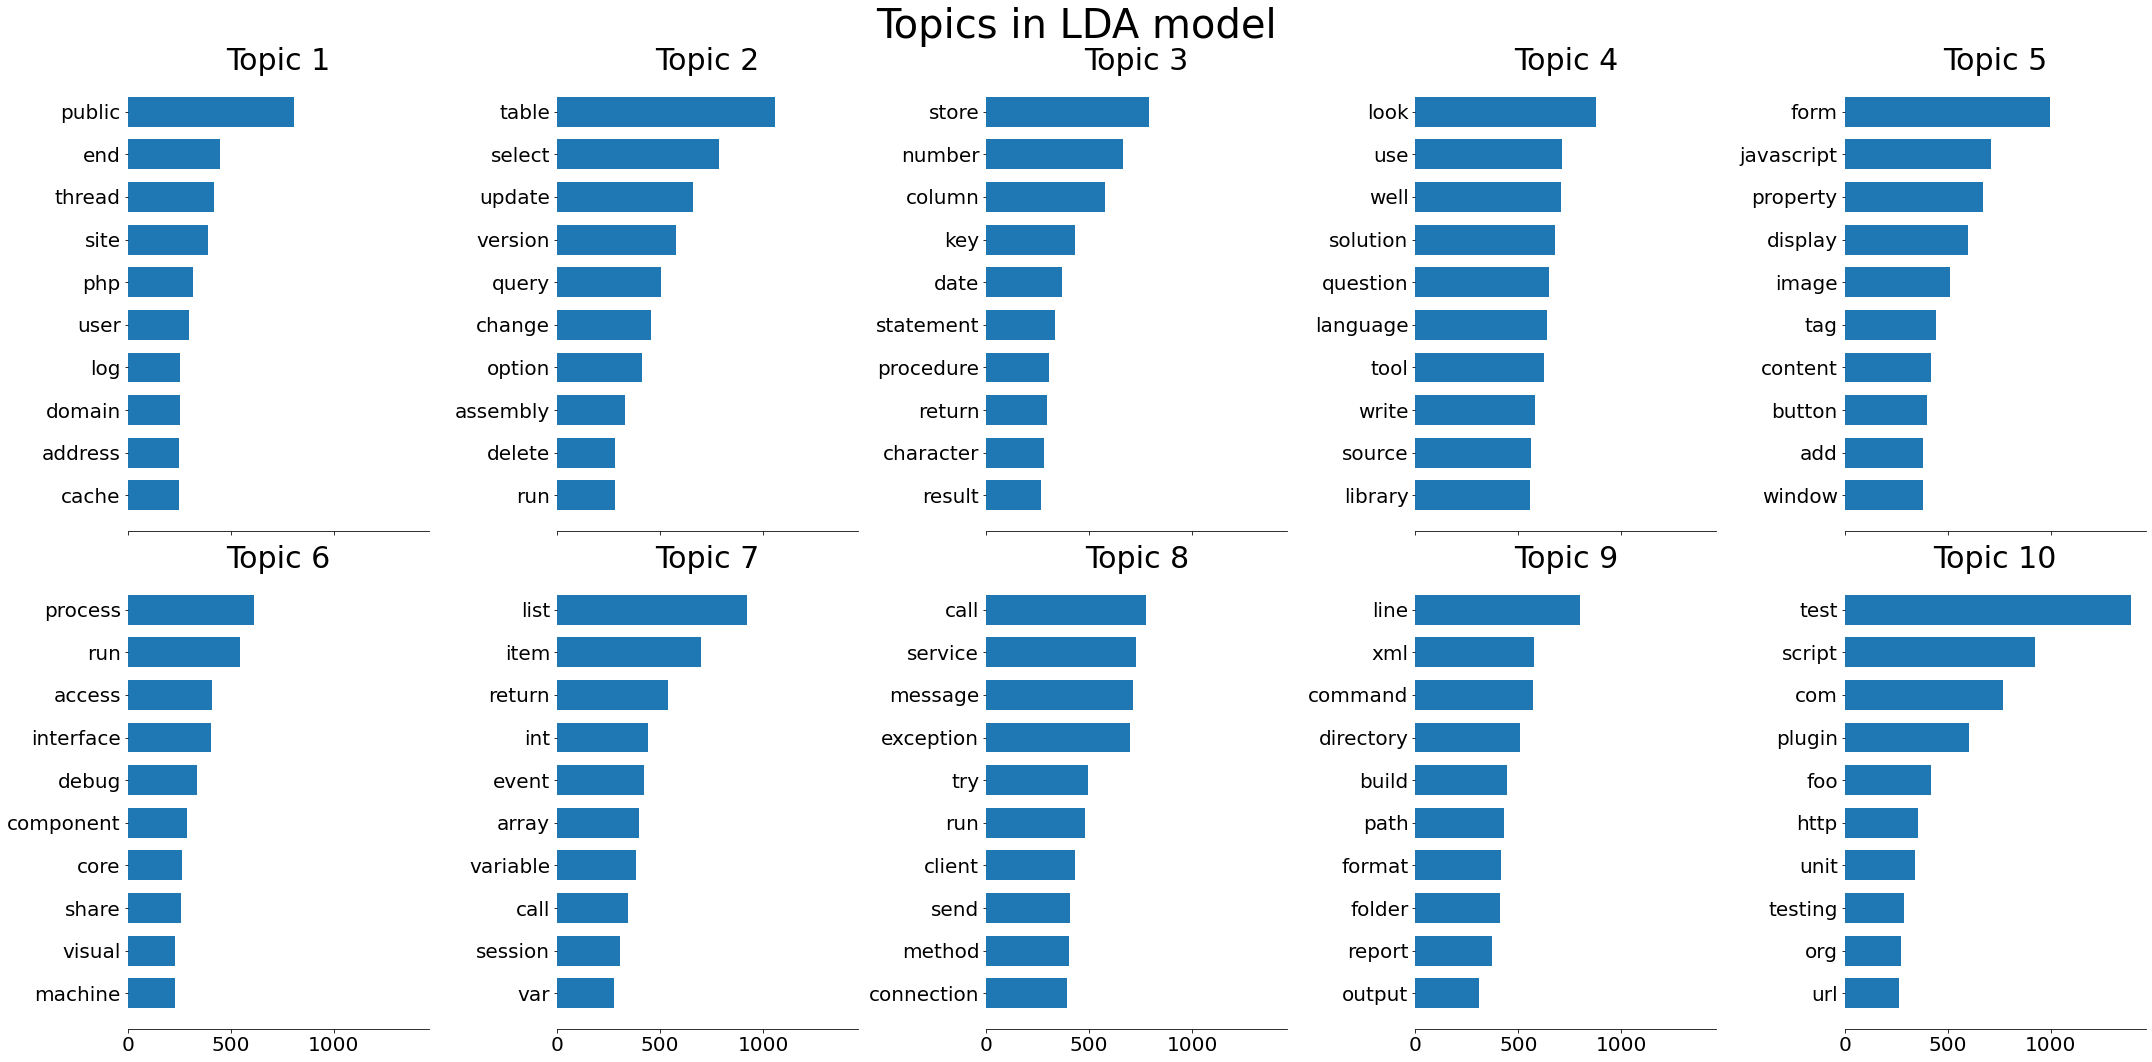

In [383]:
## LDA : 
print(
    "\n" * 2,
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components, 
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time.time()
lda.fit(tf)
print("done in %0.3fs." % (time.time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")


<a id ="section2.3"></a>
[back to menu](#menu)

## 2.C Optimisation des hyper-paramètres du LDA :
Je reviens au LDA, pour laquelle il faut fixer les "bons" choix de paramètres. Une validation croisée s'impose alors. Je construit un pipe python :
* La vectorisation a déjà été faite, je garde toutes les features quitte à ajouter une pénalisation lasso
* La LDA a différents paramètres à fixer : 
    * n_components = Number of topics.
    * max_iter=5 : The maximum number of passes over the training data (aka epochs)
    * learning_decay = 0.7 -> (0.5, 1.0] : It is a parameter that control learning rate in the online learning method.
    * learning_offset=50.0, : A (positive) parameter that downweights early iterations in online learning
* Le score proposé pour la LDA dans sklarn est la log-vraissemblance approchée. Cependant, vu que le lien texte/tag n'est pas encore traité, cela n'aura pas tant de sens de comparer à une sortie. Il sera plus intéressant de regarder la perplexité (aussi donnée dans la LDA de sklearn) Cependant, il y a l'air d'y avoir un [bug dans l'implémentation de la perplexité](https://github.com/scikit-learn/scikit-learn/issues/6777) dans sklearn.

In [354]:
def pseudo_cv_X_sparse(X_,  my_meth, param_grid, my_score, cv = 5):
    ## MAP THE DICT OF LIST INTO LIST OF DICT :
    param_dirg = model_selection.ParameterGrid(param_grid)

    ## INITIALIZATION : 
    res = {} # dict of dict 
    res["params"]=[]
    for kwargs in param_dirg :
        res["params"].append(kwargs)
    dict_score = {}
    dict_time_fit = {}
    dict_time_predict = {}

    k_iter = 1
    n_fold = 0 # just for print purpose 
    ## SET FOLDS :
    kf = model_selection.KFold(n_splits = cv)
    y=None
    CV_split_iterator = kf.split(X_,y) 

    ## LOOP ON FOLDS :
    for CV_train_range_index, CV_test_range_index in CV_split_iterator : 
        n_fold += 1 
        print("Fold "+str(n_fold))
        ## extract train
        train_index = X_.index[CV_train_range_index]
        train = X_.iloc[CV_train_range_index]
        ## extract test : 
        test_index = X_.index[CV_test_range_index]
        test = X_.iloc[CV_test_range_index]
        ## LOOP ON PARAM NAMES (HERE ONLY 1)
        fold_key = "fold"+str(k_iter)
        ## init fold dict
        dict_score[fold_key] = []
        dict_time_fit[fold_key] = []
        dict_time_predict[fold_key] = []
        ## loop on different set of kwargs 
        for kwargs in param_dirg :
            print(kwargs)
            ## SET PARAMS IN METH :
            my_meth.set_params(**kwargs)
            ## PREDICT TEST VALUES : 
            t = time.time()
            my_meth.fit(train)
            W = my_meth.transform(test)
            dict_time_fit[fold_key].append(time.time() - t)
            t = time.time()
            H = my_meth.components_
            X_pred = np.dot(W,H)
            dict_score[fold_key].append(my_score(test, X_pred))
            dict_time_predict[fold_key].append(time.time() - t)     
        k_iter += 1
    ## save in same shape as sklearn GridSearchCV     
    df_time_fit = pd.DataFrame(dict_time_fit)
    df_time_predict = pd.DataFrame(dict_time_predict)
    df_score = pd.DataFrame(dict_score)
    res["mean_fit_time"] = df_time_fit.mean(axis=1).values
    res["std_fit_time"] = df_time_fit.std(axis=1).values
    res["mean_score_time"] = df_time_predict.mean(axis=1).values
    res["std_score_time"] = df_time_predict.std(axis=1).values
    res["mean_test_score"] = df_score.mean(axis=1).values
    res["std_test_score"] = df_score.std(axis=1).values
    return(res)

In [355]:
n_features = 1000
n_components = 10
## for print :
n_top_words = 20

In [356]:
## choose vectorizer : 
countvec = CountVectorizer(max_features=n_features,
                          stop_words='english', strip_accents='unicode',)
X = countvec.fit_transform(pd.Series(corpora))
## get right index and split :
X = pd.DataFrame(X.toarray(), index = corpora.keys())
X_train = X.loc[train_index,:]
X_test = X.loc[test_index,:]

param_grid = {"n_components" : [100,500,1000,2000,5000],
              "max_iter" : [5,10,20],
              "learning_decay" : [0.7,0.8,0.9] ,
              "learning_offset" : [50,100]}

my_score = sklearn.metrics.mean_squared_error
my_meth = LatentDirichletAllocation(n_jobs = 8, verbose = 0)

In [357]:
# res = pseudo_cv_X_sparse(X_train,  my_meth, param_grid, my_score, cv = 3)
# with open(res_path+"CV_LDA"+".pkl", "wb") as f :
#     pickle.dump(res, f, pickle.HIGHEST_PROTOCOL)

In [358]:
with open(res_path+"CV_LDA"+".pkl", "rb") as f :
    res = pickle.load(f)
    
res = pd.concat((pd.DataFrame(res),pd.DataFrame(res['params'])), axis =1).drop("params", axis = 1)
res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_score,std_test_score,learning_decay,learning_offset,max_iter,n_components
0,4.168731,0.149787,0.046809,0.010979,45.688182,3.126705,0.7,50,5,100
1,7.600038,0.155918,0.058032,0.001381,10.635897,0.775504,0.7,50,5,500
2,14.707907,0.308149,0.076188,0.000659,6.508801,0.389180,0.7,50,5,1000
3,31.159872,1.902996,0.093726,0.009108,6.164688,0.096567,0.7,50,5,2000
4,85.902485,2.272121,0.143181,0.009320,22.692521,1.964681,0.7,50,5,5000


Exploration des différents résultats : 

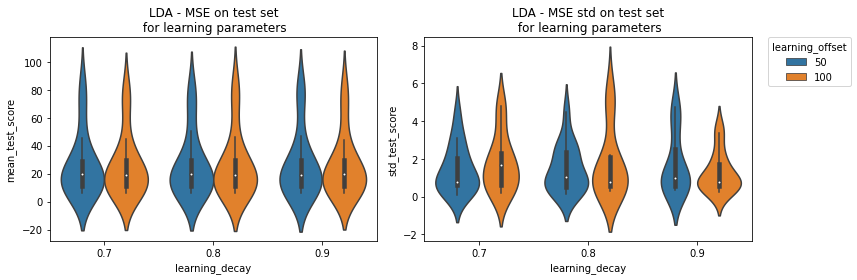

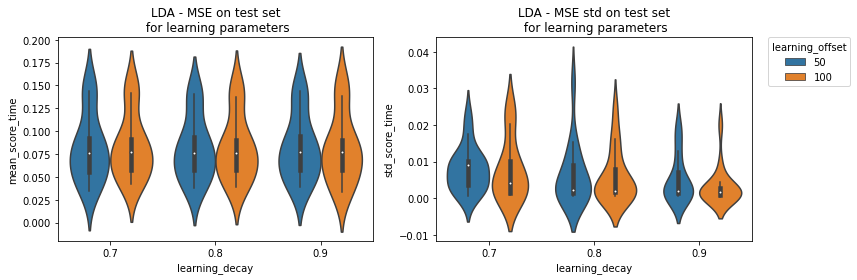

In [61]:
# MSE = f(learning_decay, learning_offset)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.violinplot(y="mean_test_score",x = "learning_decay",hue = "learning_offset", data=res)
plt.legend("",frameon=False)
plt.title("LDA - MSE on test set\n for learning parameters")

plt.subplot(1,2,2)
sns.violinplot(y="std_test_score",x = "learning_decay",hue = "learning_offset", data=res)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title= "learning_offset")
plt.title("LDA - MSE std on test set\n for learning parameters")

plt.tight_layout()
plt.show()

## time = f(learning_decay, learning_offset)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.violinplot(y="mean_score_time",x = "learning_decay",hue = "learning_offset", data=res)
plt.legend("",frameon=False)
plt.title("LDA - MSE on test set\n for learning parameters")

plt.subplot(1,2,2)
sns.violinplot(y="std_score_time",x = "learning_decay",hue = "learning_offset", data=res)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title= "learning_offset")
plt.title("LDA - MSE std on test set\n for learning parameters")

plt.tight_layout()
plt.show()

Les paramètres d'apprentissage n'ont pas d'impact sur le MSE, mais sur la robustesse des résultats (sur l'écart type des prédictions). Je garderai les paramètres qui donnent l'écart-type le plus petit.

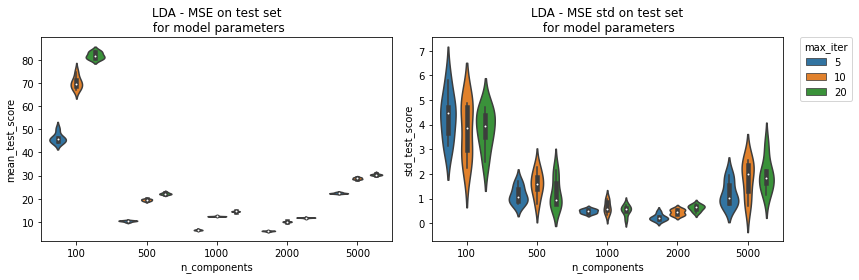

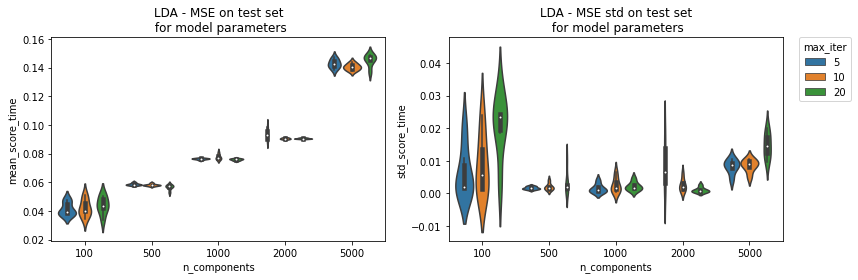

In [65]:
# MSE = f(n_components, max_iter)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.violinplot(y="mean_test_score",x = "n_components",hue = "max_iter", data=res)
plt.legend("",frameon=False)
plt.title("LDA - MSE on test set\n for model parameters")

plt.subplot(1,2,2)
sns.violinplot(y="std_test_score",x = "n_components",hue = "max_iter", data=res)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title= "max_iter")
plt.title("LDA - MSE std on test set\n for model parameters")

plt.tight_layout()
plt.show()

## time = f(n_components, max_iter)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.violinplot(y="mean_score_time",x = "n_components",hue = "max_iter", data=res)
plt.legend("",frameon=False)
plt.title("LDA - MSE on test set\n for model parameters")

plt.subplot(1,2,2)
sns.violinplot(y="std_score_time",x = "n_components",hue = "max_iter", data=res)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title= "max_iter")
plt.title("LDA - MSE std on test set\n for model parameters")

plt.tight_layout()
plt.show()

La LDA donne de meilleurs résultats pour 1000 et 2000 composantes, au delà, le MSE augmente, ainsi que le temps de calcul. Le MSE est minimal pour 5 itérations maximales. 

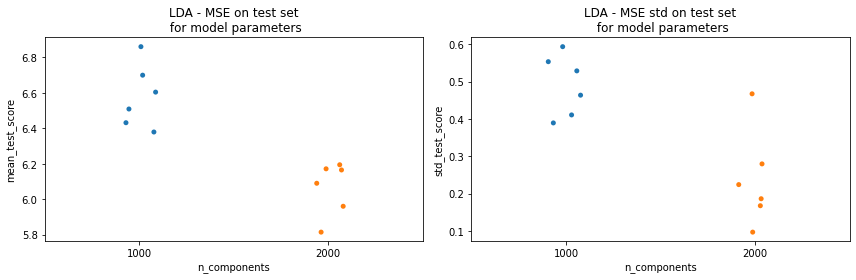

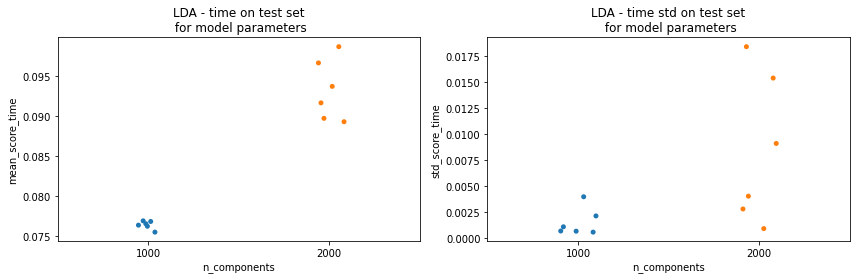

In [109]:
res2 = res[res.max_iter == 5]
res2 = res2[res2.n_components.isin([1000,2000])]
res2 = res2.astype({"n_components":"category"})

# MSE = f(n_components, max_iter)
fig, axs = plt.subplots (1, 2, figsize=(12,4))

axs[0].set_title("LDA - MSE on test set\n for model parameters")
sns.stripplot(x = "n_components", y="mean_test_score", data=res2, ax=axs[0])

axs[1].set_title("LDA - MSE std on test set\n for model parameters")
sns.stripplot(x = "n_components", y="std_test_score", data=res2, ax=axs[1])

plt.tight_layout()
plt.show()


## time = f(n_components, max_iter)
fig, axs = plt.subplots (1, 2, figsize=(12,4))

axs[0].set_title("LDA - time on test set\n for model parameters")
sns.stripplot(x = "n_components", y="mean_score_time", data=res2, ax=axs[0])

axs[1].set_title("LDA - time std on test set\n for model parameters")
sns.stripplot(x = "n_components", y="std_score_time", data=res2, ax=axs[1])

plt.tight_layout()
plt.show()

Les prédictions sont légèrement meilleures avec 2000 composantes. Les paramètres d'apprentissage n'influançant que peu, je vais les fixer à learning_rate = 0.9 et learning_offset = 100 

In [359]:
## best params : 
best_params = {
    "learning_decay" : 0.9,
    "learning_offset" : 100,
    "n_components" : 2000,
    "max_iter" : 5,
}

t0 = time.time()
lda_model = LatentDirichletAllocation(n_jobs = 8, verbose = 0, **best_params)
lda_model.fit(X_train)
print("done in %0.3fs." % (time.time() - t0))

done in 34.542s.


Pour évaluer cette partie, je me suis beaucoup inspirée de [ce travail](https://yanlinc.medium.com/how-to-build-a-lda-topic-model-using-from-text-601cdcbfd3a6)

In [267]:
print("Log Likelihood: ", lda_model.score(X_train))
## be caution : an error in sklearn mentionned above
print("Perplexity: ", lda_model.perplexity(X_train))

Log Likelihood:  -2030032.699167025
Perplexity:  3875.9419849702513


In [273]:
# Create Document — Topic Matrix
lda_output = lda_model.transform(X_train)# column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]# index names
docnames = ["Doc" + str(i) for i in range(X_train.shape[0])]# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic["dominant_topic"] = dominant_topic# Styling
def color_green(val):
    color = "green" if val > .1 else "black"
    return "color: {col}".format(col=color)
def make_bold(val):
    weight = 700 if val > .1 else 400
    return "font-weight: {weight}".format(weight=weight)# Apply Style
# df_document_topics_h = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
# df_document_topics_h

In [277]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)# Assign Column and Index
df_topic_keywords.columns = countvec.get_feature_names_out()
df_topic_keywords.index = topicnames# View
df_topic_keywords.head()

,ability,able,abstract,accept,access,accomplish,accord,account,achieve,action,...,worth,wpf,wrap,write,writing,wrong,www,xml,year,zip
Topic0,0.0005,3.574938,0.0005,0.0005,0.000500,0.000500,0.0005,0.0005,0.0005,0.000500,...,0.0005,0.0005,1.050323,0.000500,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005
Topic1,0.0005,1.352624,0.0005,0.0005,0.000500,0.026936,0.0005,0.0005,0.0005,0.000500,...,0.0005,0.0005,0.000500,0.000500,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005
Topic2,0.0005,0.000500,0.0005,0.0005,0.916566,0.000500,0.0005,0.0005,0.0005,0.617561,...,0.0005,0.0005,0.000500,0.000500,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005
Topic3,0.0005,0.000500,0.0005,0.0005,0.000500,0.000500,0.0005,0.0005,0.0005,0.000500,...,0.0005,0.0005,0.000500,0.000500,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005
Topic4,0.0005,0.000500,0.0005,0.0005,0.000500,0.000500,0.0005,0.0005,0.0005,0.000500,...,0.0005,0.0005,0.000500,7.212528,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005


In [283]:
## get the 10 most important word in each topic :
# Show top n keywords for each topic
def show_topics(vectorizer=countvec, lda_model=lda_model, n_words=10):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=countvec, lda_model=lda_model, n_words=10)

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,exception,handler,happen,handle,far,possible,event,run,able,message
Topic 1,tree,look,use,structure,need,solve,require,provide,represent,include
Topic 2,delete,publish,say,run,sure,right,make,change,require,really
Topic 3,ability,practice,pre,prefer,preferably,present,press,pretty,prevent,previous
Topic 4,miss,really,try,say,feature,actually,require,write,think,come
...,...,...,...,...,...,...,...,...,...,...
Topic 1995,win,run,different,currently,hardware,unique,write,happen,result,version
Topic 1996,appear,constraint,ui,ability,pre,prefer,preferably,present,press,pretty
Topic 1997,ability,practice,pre,prefer,preferably,present,press,pretty,prevent,previous
Topic 1998,wrong,sure,fine,trigger,actually,idea,think,work,try,start


Et en reprenant les représentations des mots prépondérants par topic comme proposé dans [sklearn](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py)

In [319]:
def plot_top_words_5(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30,10), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_[:5]):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        
        ax = axes[topic_idx]
#         ax.set_xlim((.9*min(weights),1.1*max(weights)))
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
        

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.tight_layout()
    plt.show()

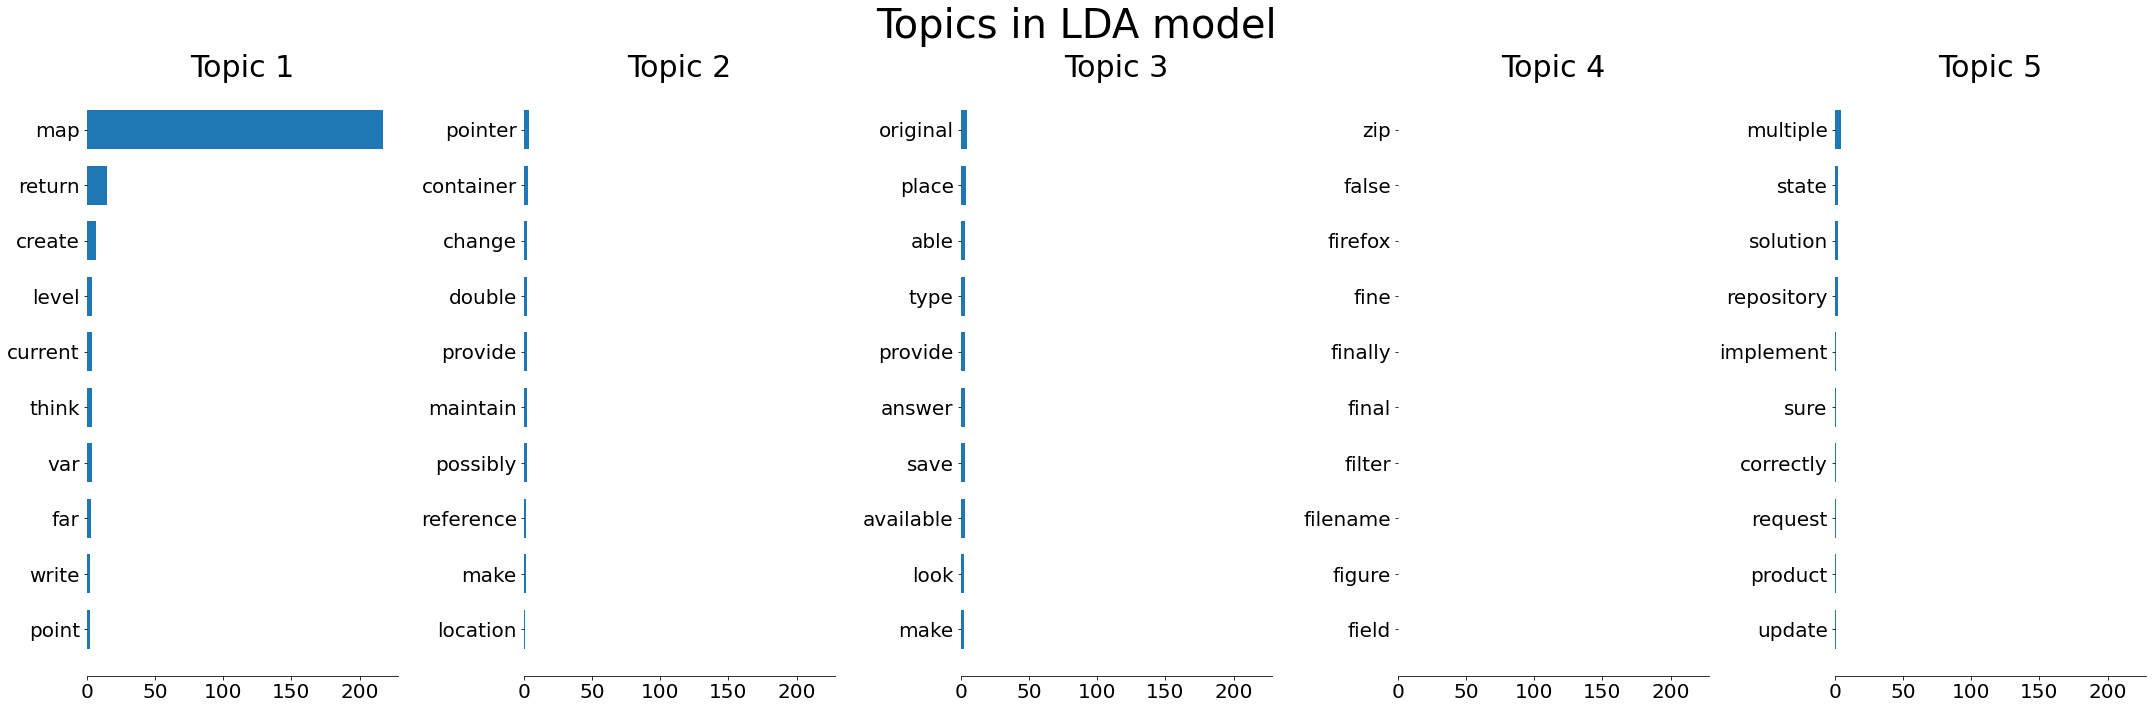

In [320]:
tf_feature_names = countvec.get_feature_names_out()
n_top_words = 10
plot_top_words_5(lda, tf_feature_names, n_top_words, "Topics in LDA model")

Bien que les données soient statistiquement mieux résumées avec 2000 composantes, il y en a trop pour pouvoir les traiter rapidement (comme en donnant un label à chaque classe). Je relance la LDA avec moins de classe pour présenter la démarche en gagnant du temps. 

In [284]:
## choose vectorizer : 
countvec = CountVectorizer(max_features=n_features,
                          stop_words='english', strip_accents='unicode',)
X = countvec.fit_transform(pd.Series(corpora))
## get right index and split :
X = pd.DataFrame(X.toarray(), index = corpora.keys())
X_train = X.loc[train_index,:]
X_test = X.loc[test_index,:]

param_grid = {"n_components" : [20],
              "max_iter" : [5,10,20],
              "learning_decay" : [0.7,0.8,0.9] ,
              "learning_offset" : [50,100]}

my_score = sklearn.metrics.mean_squared_error
my_meth = LatentDirichletAllocation(n_jobs = 8, verbose = 0)

In [288]:
# res = pseudo_cv_X_sparse(X_train,  my_meth, param_grid, my_score, cv = 3)
# with open(res_path+"CV_LDA_small"+".pkl", "wb") as f :
#     pickle.dump(res, f, pickle.HIGHEST_PROTOCOL)

with open(res_path+"CV_LDA_small"+".pkl", "rb") as f :
    res = pickle.load(f)
    
res = pd.concat((pd.DataFrame(res),pd.DataFrame(res['params'])), axis =1).drop("params", axis = 1)
res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_score,std_test_score,learning_decay,learning_offset,max_iter,n_components
0,3.871092,0.075068,0.037246,0.003751,458.594154,39.395223,0.7,50,5,20
1,5.471821,0.441186,0.037739,0.004562,663.495223,64.601442,0.7,50,10,20
2,8.896921,0.383469,0.031421,0.006669,681.505430,33.858481,0.7,50,20,20
3,3.988453,0.199684,0.033575,0.002652,487.705142,37.189865,0.7,100,5,20
4,5.705815,0.271925,0.031955,0.004583,622.067470,68.314112,0.7,100,10,20


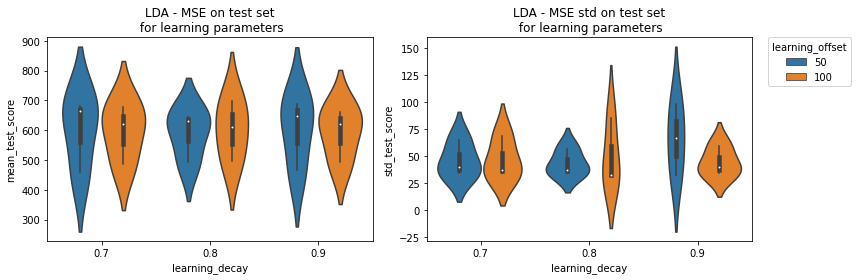

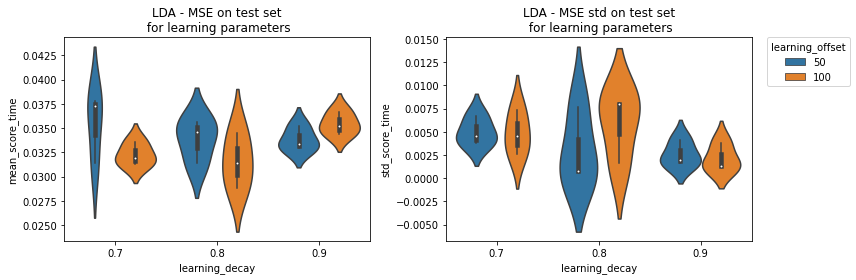

In [289]:
# MSE = f(learning_decay, learning_offset)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.violinplot(y="mean_test_score",x = "learning_decay",hue = "learning_offset", data=res)
plt.legend("",frameon=False)
plt.title("LDA - MSE on test set\n for learning parameters")

plt.subplot(1,2,2)
sns.violinplot(y="std_test_score",x = "learning_decay",hue = "learning_offset", data=res)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title= "learning_offset")
plt.title("LDA - MSE std on test set\n for learning parameters")

plt.tight_layout()
plt.show()

## time = f(learning_decay, learning_offset)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.violinplot(y="mean_score_time",x = "learning_decay",hue = "learning_offset", data=res)
plt.legend("",frameon=False)
plt.title("LDA - MSE on test set\n for learning parameters")

plt.subplot(1,2,2)
sns.violinplot(y="std_score_time",x = "learning_decay",hue = "learning_offset", data=res)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title= "learning_offset")
plt.title("LDA - MSE std on test set\n for learning parameters")

plt.tight_layout()
plt.show()

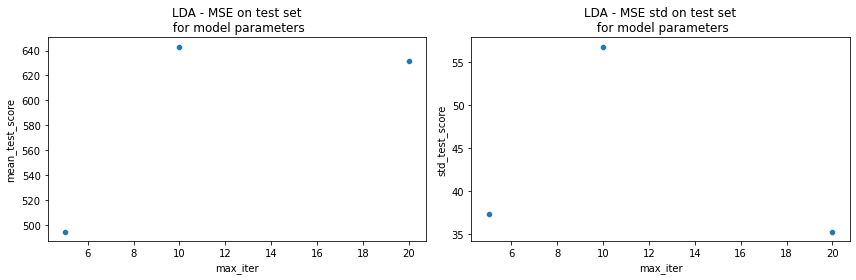

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_score,std_test_score,learning_decay,learning_offset,max_iter,n_components
6,4.023021,0.163657,0.034588,0.000708,494.783426,37.360740,0.8,50,5,20
7,5.666318,0.158409,0.031374,0.007694,643.108002,56.835022,0.8,50,10,20
8,9.027814,0.319854,0.035610,0.000731,631.731069,35.254802,0.8,50,20,20


In [301]:
res2 = res[res.learning_offset == 50]
res2 = res2[res2.learning_decay == 0.8]

# MSE = f(n_components, max_iter)
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title("LDA - MSE on test set\n for model parameters")
sns.scatterplot(x = "max_iter", y="mean_test_score", data=res2)
plt.subplot(1,2,2)
plt.title("LDA - MSE std on test set\n for model parameters")
sns.scatterplot(x = "max_iter", y="std_test_score", data=res2)

plt.tight_layout()
plt.show()
res2

In [360]:
## best params : 
best_params_small = { "learning_decay" : 0.8, "learning_offset" : 50,
                "n_components" : 20, "max_iter" : 5 }

t0 = time.time()
lda_model_small = LatentDirichletAllocation(n_jobs = 8, verbose = 0, **best_params_small)
lda_model_small.fit(X_train)
print("done in %0.3fs." % (time.time() - t0))

done in 3.690s.


In [362]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model_small.components_)# Assign Column and Index
df_topic_keywords.columns = countvec.get_feature_names_out()
df_topic_keywords.index = ["Topic" + str(i) for i in range(lda_model_small.n_components)]# index names

df_topic_keywords

,ability,able,abstract,accept,access,accomplish,accord,account,achieve,action,...,worth,wpf,wrap,write,writing,wrong,www,xml,year,zip
Topic0,0.050000,43.905223,0.050000,0.071871,35.359598,11.964140,0.050941,32.474486,0.101169,2.021612,...,13.812248,121.789319,6.848561,53.782202,5.793842,3.265874,0.102333,0.411056,16.392674,0.050000
Topic1,5.760058,65.067028,0.050000,0.050000,96.425305,7.945788,1.605285,13.718448,5.902610,5.311449,...,7.832176,0.050004,0.052286,98.276762,0.387017,7.330490,0.050000,11.820065,0.096924,0.050000
Topic2,0.814419,33.204001,2.111578,5.629149,196.300918,2.680633,7.781824,4.087435,3.888026,9.249564,...,0.050413,1.209159,0.414320,27.973877,3.410043,8.798100,0.440705,44.189960,0.050000,0.050000
Topic3,17.491654,45.238597,0.050000,0.552338,31.292284,3.041117,5.651681,0.979726,17.130826,1.046097,...,0.050000,0.050002,17.938958,129.152571,7.239926,10.435216,0.072514,0.617839,18.696256,0.050000
Topic4,0.482811,40.253216,7.543102,10.339180,10.410549,0.507678,6.775744,0.549119,5.499460,0.059274,...,0.050000,2.238782,8.490151,46.893667,1.537812,2.887825,0.050000,7.763140,3.505775,0.050000
Topic5,0.112189,45.532373,0.930354,17.367236,9.311563,3.509949,8.418054,2.069200,7.683138,0.050000,...,1.598532,3.240918,36.638791,54.241187,0.050000,33.671759,0.189643,421.740871,0.136093,0.050000
Topic6,7.132013,74.107273,0.050000,6.492289,35.021375,8.483561,3.030931,0.366396,1.732462,1.606207,...,0.050000,0.050000,0.057851,225.913009,10.901334,5.278318,0.491710,0.050000,1.995892,1.347061
Topic7,0.050000,44.006320,2.335097,6.250852,3.598041,1.590746,1.501469,0.325295,2.774299,13.512840,...,0.050000,23.010234,5.589720,24.991002,0.226327,35.436723,0.257201,0.426739,0.050000,0.050000
Topic8,4.144159,50.634931,0.290933,0.378654,73.482105,2.406687,0.050000,39.343263,8.771330,2.779042,...,0.974930,0.289533,0.050000,40.319271,4.053013,12.266353,0.654246,0.050000,0.050239,0.050000
Topic9,0.112191,30.777824,0.050000,12.475144,8.158314,0.504221,0.050000,5.387160,1.803780,7.433281,...,0.173486,0.050000,3.228854,14.169815,11.849656,10.851454,1.228366,9.164416,0.053610,0.050000


In [315]:
topic_keywords = show_topics(vectorizer=countvec, lda_model=lda_model_small, n_words=10)

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,store,folder,memory,end,procedure,address,tool,download,use,connection
Topic 1,list,foo,option,select,item,bar,library,var,block,add
Topic 2,com,xml,http,document,content,map,www,structure,tree,implement
Topic 3,path,run,connect,script,task,connection,video,oracle,number,remote
Topic 4,service,message,build,framework,visual,eclipse,wcf,studio,client,silverlight
Topic 5,tag,sort,result,query,order,collection,case,list,cache,select
Topic 6,test,search,result,point,index,number,ajax,pass,request,run
Topic 7,test,report,unit,query,method,table,access,write,testing,size
Topic 8,line,thread,log,email,org,send,message,run,program,command
Topic 9,table,update,column,change,row,command,select,key,script,lock


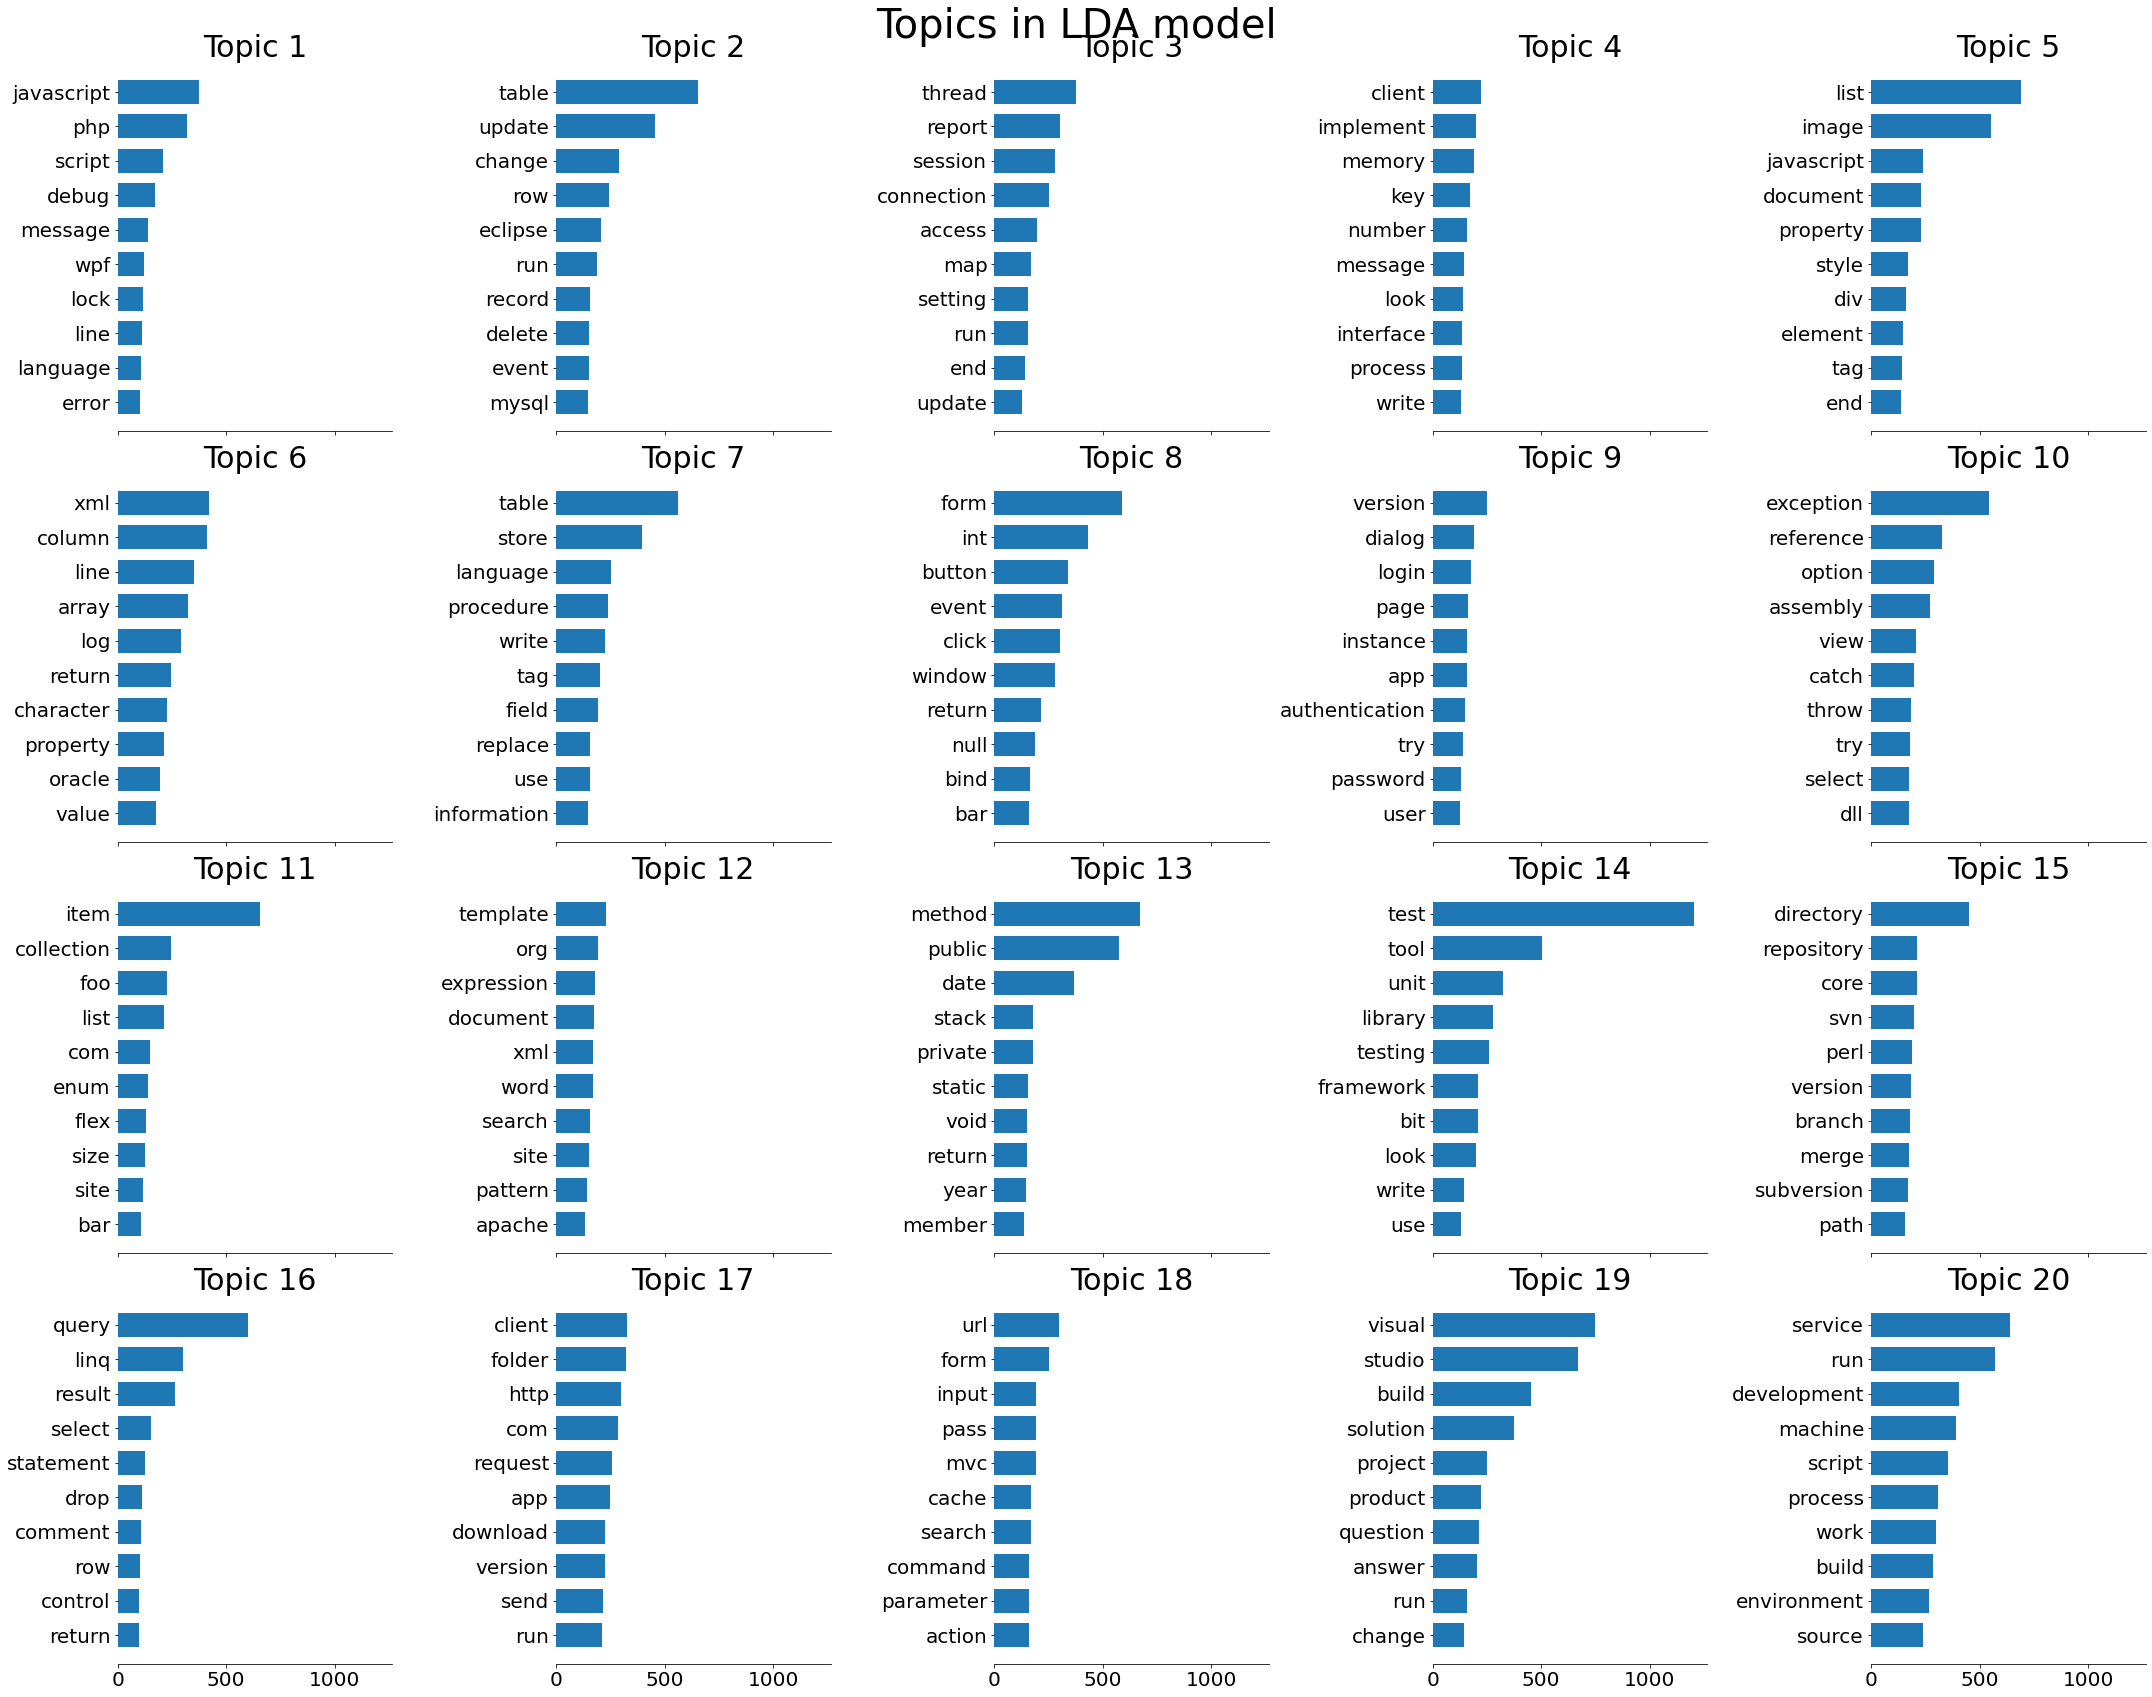

In [392]:
tf_feature_names = countvec.get_feature_names_out()
n_top_words = 10
plot_top_words(lda_model_small, tf_feature_names, n_top_words, "Topics in LDA model", n5 = 4,)

De ces listes, on peut extraire un topic général comme "manipulation_table" pour le topic 16, ou "controle_version_system" pour le topic 15.

<a id ="section2.4"></a>
[back to menu](#menu)

## 2.D LDA - modèle sur test :

In [393]:
X_pred = lda.transform(X_test)


TypeError: unhashable type: 'numpy.ndarray'

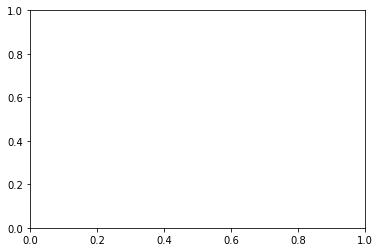

In [256]:
feature_names = countvec.get_feature_names_out()

topic = X_test[1]
topic = topic.reset_index().drop("index", axis=1)
topic = np.array(topic)
top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
top_features = [feature_names[i] for i in top_features_ind]
weights = topic[top_features_ind]

# ax = axes[topic_idx]
#         ax.set_xlim((.9*min(weights),1.1*max(weights)))
plt.barh(top_features, weights, height=0.7)
plt.title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
plt.invert_yaxis()
plt.tick_params(axis="both", which="major", labelsize=20)
for i in "top right left".split():
    plt.spines[i].set_visible(False)

In [258]:
top_features

[array(['ability'], dtype=object),
 array(['ability'], dtype=object),
 array(['ability'], dtype=object),
 array(['ability'], dtype=object),
 array(['ability'], dtype=object),
 array(['ability'], dtype=object),
 array(['ability'], dtype=object),
 array(['ability'], dtype=object),
 array(['ability'], dtype=object),
 array(['ability'], dtype=object)]

In [237]:
feature_names

array(['ability', 'able', 'abstract', 'accept', 'access', 'accomplish',
       'accord', 'account', 'achieve', 'action', 'active', 'actual',
       'actually', 'add', 'additional', 'address', 'admin',
       'administrator', 'advantage', 'advice', 'ago', 'ajax', 'alert',
       'algorithm', 'allow', 'alter', 'alternative', 'analysis', 'answer',
       'apache', 'api', 'app', 'appear', 'append', 'application', 'apply',
       'appreciate', 'approach', 'appropriate', 'architecture', 'area',
       'argument', 'array', 'article', 'ask', 'aspx', 'assembly',
       'assign', 'associate', 'assume', 'attach', 'attempt', 'attribute',
       'audio', 'authentication', 'author', 'auto', 'automate',
       'automatically', 'available', 'avoid', 'aware', 'away',
       'background', 'backup', 'bad', 'bar', 'base', 'basic', 'basically',
       'batch', 'begin', 'behavior', 'behaviour', 'believe', 'benefit',
       'big', 'binary', 'bind', 'bit', 'block', 'blog', 'body', 'book',
       'bool', 'bool

In [262]:
for index, score in sorted(lda[X_test[0]], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda.print_topic(index, 5)))

TypeError: 'LatentDirichletAllocation' object is not subscriptable

NameError: name 'title' is not defined

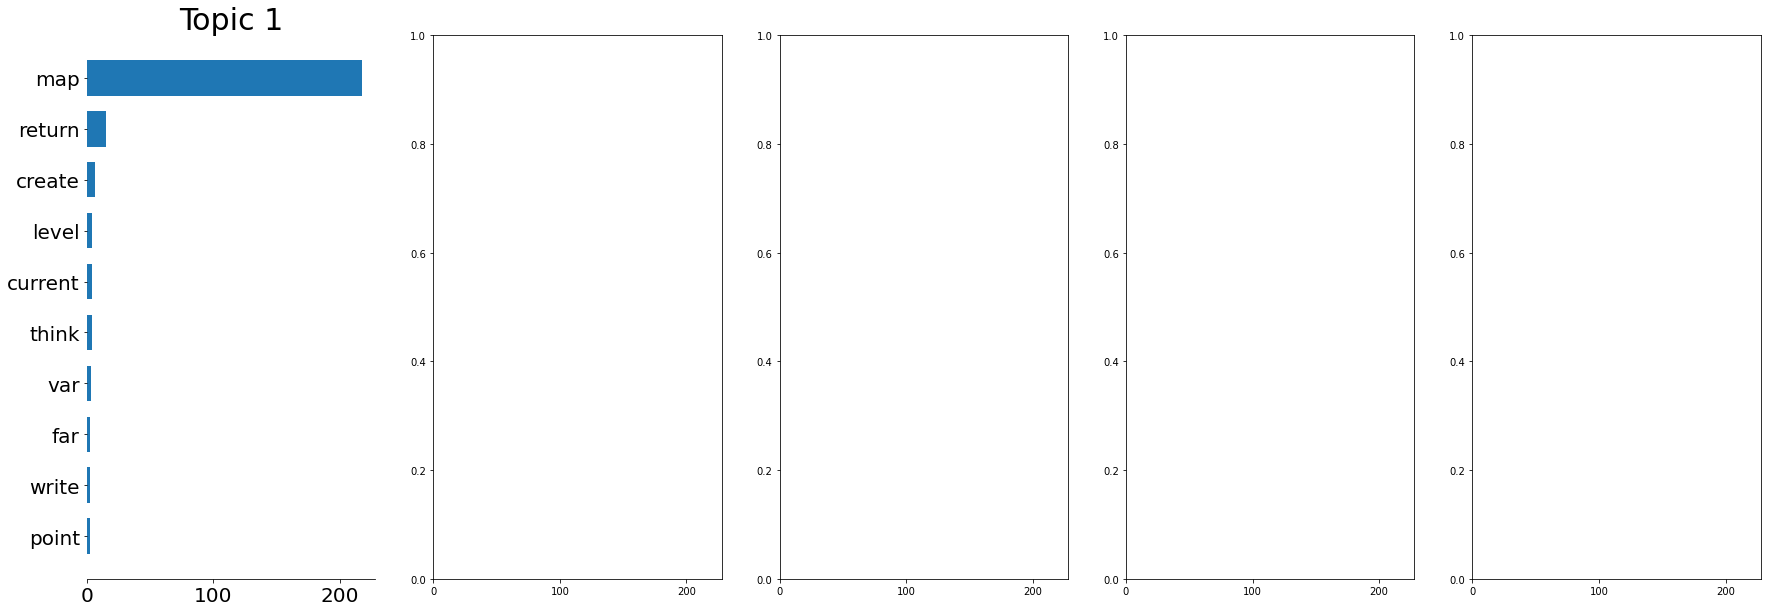

In [259]:
fig, axes = plt.subplots(1, 5, figsize=(30,10), sharex=True)
axes = axes.flatten()
for topic_idx, topic in enumerate(lda.components_[:5]):
    top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]

    ax = axes[topic_idx]
#         ax.set_xlim((.9*min(weights),1.1*max(weights)))
    ax.barh(top_features, weights, height=0.7)
    ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
    ax.invert_yaxis()
    ax.tick_params(axis="both", which="major", labelsize=20)
    for i in "top right left".split():
        ax.spines[i].set_visible(False)
    fig.suptitle(title, fontsize=40)


<a id ="section3"></a>
<a id ="section3.1"></a>
[back to menu](#menu)

# 3. Approche supervisée

## 3.1 Gradient Boosting uniclass : 

In [405]:
from sklearn.ensemble import GradientBoostingClassifier
n_estimators = 400
max_leaf_nodes = 4
max_depth = None

gradient_boosting = GradientBoostingClassifier(
    n_estimators=n_estimators, max_leaf_nodes = max_leaf_nodes, max_depth=max_depth, 
    n_iter_no_change = 100, random_state=10
)

## train : 
gradient_boosting.fit(X_train, y_train)

## test :
y_pred = gradient_boosting.predict(X_test)
print("Accuracy with default params", 
      gradient_boosting.score(X_test,y_test),
      "on test set")

Une validation croisée permet de choisir les paramètres optimaux : 

In [421]:
from sklearn.model_selection import GridSearchCV
param_grid = {"learning_rate" : [0.05, 0.1, 0.2, 0.5],
              "n_estimators" : [100,200,500],
              "max_depth" : [3,5,10]}

gradient_boosting = GradientBoostingClassifier(n_iter_no_change=100, random_state=10)
boost_CV = GridSearchCV(gradient_boosting, param_grid, n_jobs=8, cv=5)

boost_CV.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(n_iter_no_change=100,
                                                  random_state=10),
             n_jobs=8,
             param_grid={'learning_rate': [0.05, 0.1, 0.2, 0.5],
                         'max_depth': [3, 5, 10],
                         'n_estimators': [100, 200, 500]})

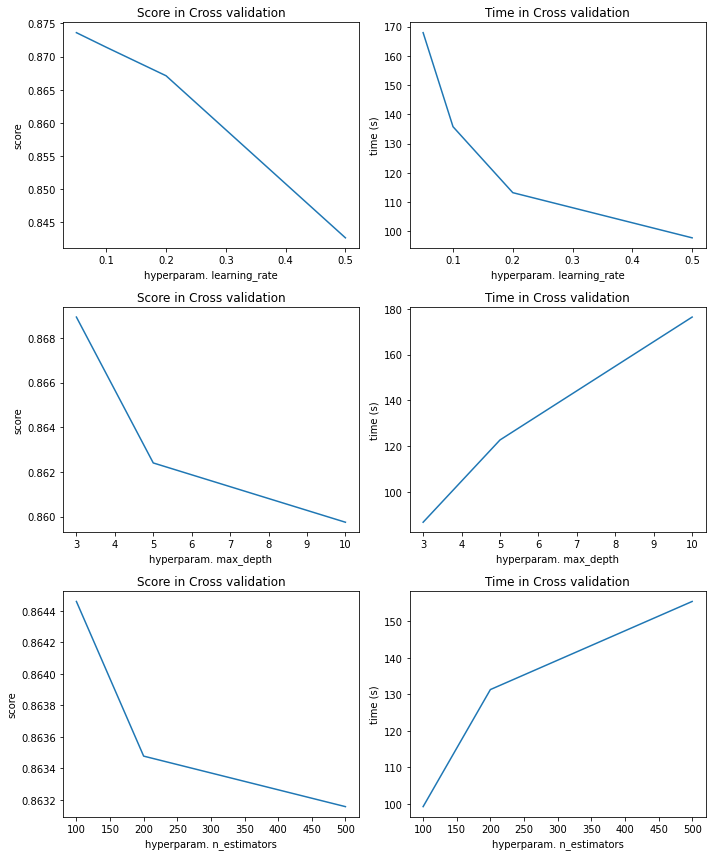

In [429]:
dict_log_param = {'learning_rate': False,
                     'n_estimators': False,
                     'max_depth': False}
plot_cv_res(boost_CV.cv_results_, dict_log_param)
plt.tight_layout()

In [434]:
boost_CV.get_params()

{'cv': 5,
 'error_score': nan,
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'friedman_mse',
 'estimator__init': None,
 'estimator__learning_rate': 0.1,
 'estimator__loss': 'deviance',
 'estimator__max_depth': 3,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_iter_no_change': 100,
 'estimator__random_state': 10,
 'estimator__subsample': 1.0,
 'estimator__tol': 0.0001,
 'estimator__validation_fraction': 0.1,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': GradientBoostingClassifier(n_iter_no_change=100, random_state=10),
 'n_jobs': 8,
 'param_grid': {'learning_rate': [0.05, 0.1, 0.2, 0.5],
  'n_estimators': [100, 200, 500],
  'max_depth': [3, 5, 10]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 's

La perte utilisée est la ["deviance"](https://stats.stackexchange.com/questions/157870/scikit-binomial-deviance-loss-function) et le score est l'accuracy. L'accuracy étant optimale à un, on veut qu'il soit le plus grand possible. Ainsi, les paramètres sont fixés à 
* n_estimator = 100
* max_depth = 3
* learning_rate = 0.05

Le meilleur modèle est relancé sur l'intégralité du jeu d'entrainement :

In [438]:
n_estimator = 100
max_depth = 3
learning_rate = 0.05
print(boost_CV.best_params_)

gradient_boosting_model = GradientBoostingClassifier(n_iter_no_change=100, random_state=10, 
                                                     **boost_CV.best_params_)
gradient_boosting_model.fit(X_train,y_train)

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


GradientBoostingClassifier(learning_rate=0.05, n_iter_no_change=100,
                           random_state=10)

Et les prédictions sur le jeu de test sont les suivantes : 

In [440]:
gradient_boosting_model.score(X_test,y_test)

0.8777937995674117

<a id ="section3.2"></a>
[back to menu](#menu)


## 3.2 Gradient Boosting multiclass  : 

La même méthodologie est utilisée pour le multiclass, avec le "HistGradientBoostingClassifier" [comme recommandé dans la doc sklearn](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting)

In [446]:
from sklearn.ensemble import HistGradientBoostingClassifier
loss = "categorical_crossentropy"
learning_rate = 0.1
max_leaf_nodes = 31
max_depth = None
min_samples_leaf = Y.shape[1]

gradient_boosting2 = HistGradientBoostingClassifier(
    loss=loss,
    learning_rate=learning_rate,
    max_leaf_nodes = max_leaf_nodes,
    max_depth=max_depth, 
    min_samples_leaf=min_samples_leaf,
    n_iter_no_change = 100, random_state=10
)

## train : 
gradient_boosting2.fit(X_train, Y_train)

## test :
Y_pred = gradient_boosting2.predict(X_test)
print("Accuracy with default params", 
      gradient_boosting2.score(X_test,Y_test),
      "on test set")

ValueError: y should be a 1d array, got an array of shape (8321, 12) instead.

In [451]:
from sklearn.tree import DecisionTreeClassifier
criterion = "gini"
max_leaf_nodes = 31
max_depth = None
min_samples_leaf = Y.shape[1]
class_weight = "balanced"

gradient_boosting2 = DecisionTreeClassifier(
    criterion=criterion,
    max_leaf_nodes = max_leaf_nodes,
    max_depth=max_depth, 
    min_samples_leaf=min_samples_leaf,
)

## train : 
gradient_boosting2.fit(X_train, Y_train)

## test :
Y_pred = gradient_boosting2.predict(X_test)
print("Accuracy with default params", 
      gradient_boosting2.score(X_test,Y_test),
      "on test set")

Accuracy with default params 0.6149963950973324 on test set


In [441]:
from sklearn.model_selection import GridSearchCV
param_grid = {"learning_rate" : [0.05, 0.1, 0.2, 0.5],
              "n_estimators" : [100,200,500],
              "max_depth" : [3,5,10]}

gradient_boosting2 = GradientBoostingClassifier(n_iter_no_change=100, random_state=10)
boost_CV2 = GridSearchCV(gradient_boosting2, param_grid, n_jobs=8, cv=5)

boost_CV2.fit(X_train, Y_train)

/home/clairegayral/.env_python/openclassroom/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
180 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/home/clairegayral/.env_python/openclassroom/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clairegayral/.env_python/openclassroom/lib/python3.9/site-packages/sklearn/ensemble/_gb.py", line 494, in fit
    y = column_or_1d(y, warn=True)
  File "/home/clairegayral/.env_python/openclassroom/lib/python3.9/site-packages/sklearn/

ValueError: y should be a 1d array, got an array of shape (8321, 12) instead.

In [ ]:
dict_log_param = {'learning_rate': False,
                     'n_estimators': False,
                     'max_depth': False}
plot_cv_res(boost_CV.cv_results_, dict_log_param)
plt.tight_layout()